### Summary of Key Findings

KMeans-clustering identified 4 groups based on our customers' spending habbits (Recency, Frequency, and Monetary value). Summarized as:

**All Groups** (excluding 1.5% outliers)
* Median Recency 50 days, although the range is wide
* Median Frequency 1-38x 
* Median Monetary is 650, max of 20,000

Group 1 ***Most customers*** (55% of customers => **30% of sales**)
* Frequency is low (median 2x and max of 9x) 
* Monetary is low (median 600, max below 4,000) 

Group 2 ***High potential*** (23% of customers => **40% of sales**)  
* On average, they bought not so long ago (median 16 says); although the max is almost 10 months ago 
* Frequency tends to be a lot higher than Group 1 (median of 9x) 
* Median monetary value 4.5x that of Group 1 
* **To-do**: more engaged, higher spending, could be a focus group

Group 3 - ***Lost customers*** (18% of customers => **7% of sales**)
* Last purchase was at least over 4 months ago 
* Did not purchase often, and median spending was low 

Group 4 - ***Best customers*** (3% of customers => **23% of sales**)
* High Frequency, high Monetary  
* **To-do**: follow up with those with high recency 

In [322]:
summ_value = pd.DataFrame(value, columns=['Group', '% of sales']); summ_value

,Group,% of sales
0,1,30.6
1,2,39.9
2,3,7.1
3,4,22.5


In [324]:
final

,Minimum,Median,Maximum
Group,ALL,,
Recency,0,50,373
Frequency,1,3,38
Monetary,1.46,668.23,19543.8
Group,1,,
Recency,0,41,156
Frequency,1,2,9
Monetary,1.46,596.28,3857.85
Group,2,,
Recency,0,16,289


## Detailed Analysis

In [25]:
import pandas as pd
import numpy as np
import feather 

from sklearn import preprocessing 
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
sns.set()

In [86]:
raw_data = feather.read_dataframe("data_RFM.feather")
raw_data.head()

,CustomerID,Recency,Frequency,Monetary
0,18102,0.0,95,341776.73
1,14646,9.0,87,243853.05
2,14156,6.0,138,183180.55
3,14911,0.0,270,137675.91
4,13694,8.0,105,128172.42


In [87]:
raw_data.shape

(4288, 4)

### Outliers Treatment

k-means is sensitive to outliers. let's examine the distributions

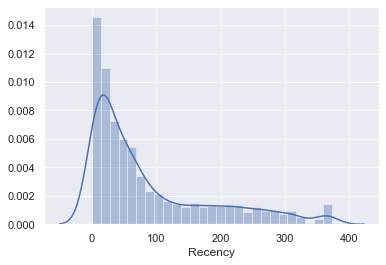

In [104]:
sns.distplot(raw_data['Recency'])

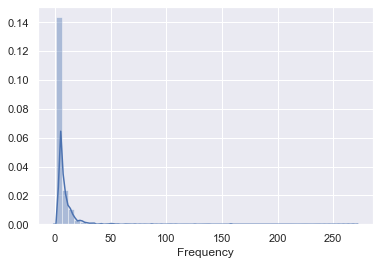

In [105]:
sns.distplot(raw_data['Frequency'])

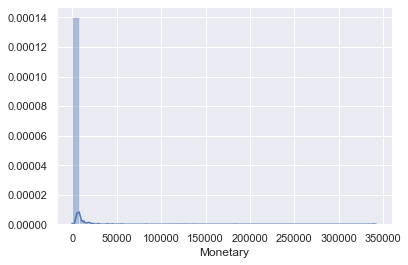

In [61]:
sns.distplot(raw_data['Monetary'])

We see that outliers for Frequency and Monetary are pronounced. Let's take out values > 99% percentile of either of these categories   
In total we will remove 1.4% of the data

In [57]:
max_f = raw_data['Frequency'].quantile(0.99); max_f

38.13000000000011

In [58]:
max_m = raw_data['Monetary'].quantile(0.99); max_m

19557.57710000001

In [97]:
data = raw_data[(raw_data['Frequency'] < max_f) & (raw_data['Monetary'] < max_m)]

#percentage that will be deleted 
(raw_data.shape[0] - data.shape[0]) / raw_data.shape[0] * 100

### Feature Scaling
k-means clustering is very sensitive to scale and outliers 

In [189]:
x_unscaled = data.drop(['CustomerID'], axis = 1)

In [190]:
X = preprocessing.scale(x_unscaled); X

array([[-0.8201696 ,  0.48855455,  9.18085468],
       [-0.68491132,  3.51127131,  8.59132355],
       [-0.40399029,  1.89915571,  8.23437667],
       ...,
       [ 0.53241316, -0.72053215, -0.69381313],
       [ 2.79018591, -0.72053215, -0.69421741],
       [-0.0918558 , -0.5190177 , -0.69497039]])

In [191]:
X.mean(axis=0)

array([ 2.68953957e-17, -5.37907914e-17,  0.00000000e+00])

In [192]:
X.std(axis=0)

array([1., 1., 1.])

Let's visualize the data before applying k-means

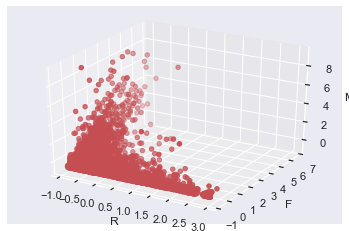

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = x_scaled[:,0]
y = x_scaled[:,1]
z = x_scaled[:,2]

ax.scatter(x, y, z, c = 'r', marker = 'o')
#ax.scatter(x,y,z, marker="s", c=df["Cluster"], s=40, cmap="RdBu")

ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')

plt.show()

### K-Means Clustering
We will look at 3 clusters, then use the Elbow Method to determine a more optimal K

In [175]:
kmeans = KMeans(n_clusters=3, n_init=50, random_state=42)
identified_c = kmeans.fit_predict(X)

In [176]:
df_clusters = data.copy()
df_clusters['Clusters'] = identified_c

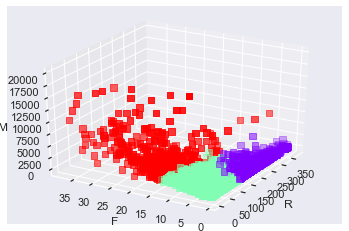

In [177]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df_clusters['Recency']
y = df_clusters['Frequency']
z = df_clusters['Monetary']

ax.scatter(x, y, z, marker="s", c=df_clusters["Clusters"], s=40, cmap="rainbow")

ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')

#print(ax.azim)
ax.view_init(azim=210)

plt.show()

#### Elbow Method

In [178]:
def find_elbow(df, kmax):
    score = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
        kmeans.fit(df)
        score.append(kmeans.inertia_)
    return score

scores = find_elbow(X, 10)

<function matplotlib.pyplot.show(*args, **kw)>

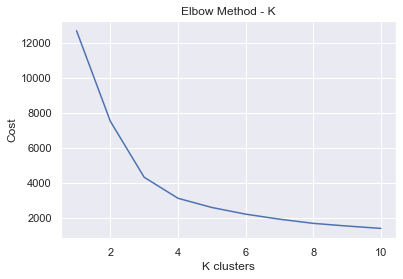

In [179]:
plt.plot(range(1,11), scores)
plt.title("Elbow Method - K")
plt.xlabel("K clusters")
plt.ylabel("Cost")
plt.show

In [180]:
kmeans = KMeans(n_clusters=4, n_init=50, random_state=42)
identified_c = kmeans.fit_predict(X)
identified_c

array([3, 3, 3, ..., 0, 2, 0])

In [196]:
df_clusters = data.copy()
df_clusters['Clusters'] = identified_c + 1
df_clusters

,CustomerID,Recency,Frequency,Monetary,Clusters
43,12415,10.0,7,19543.84,4
47,14258,23.0,22,18377.27,4
51,18008,50.0,14,17670.94,4
52,15856,0.0,28,17643.77,4
54,16210,3.0,21,17217.76,4
...,...,...,...,...,...
4283,15040,176.0,1,7.49,3
4284,15913,169.0,1,6.30,3
4285,13788,140.0,1,3.75,1
4286,14095,357.0,1,2.95,3


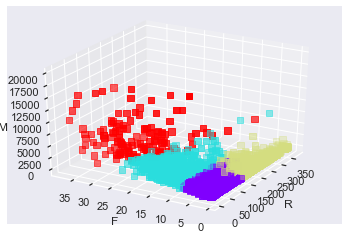

In [197]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df_clusters['Recency']
y = df_clusters['Frequency']
z = df_clusters['Monetary']

ax.scatter(x, y, z, marker="s", c=df_clusters["Clusters"], s=40, cmap="rainbow")

ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')

#print(ax.azim)
ax.view_init(azim=210)

plt.show()

### Analyzing Clusters

In [207]:
measures = ['Recency', 'Frequency', 'Monetary']
measures

['Recency', 'Frequency', 'Monetary']

In [286]:
#dataframe summary of ALL groups

summ = [['ALL',' ',' ']]
for m in measures:
    a = []
    a.append(np.min(df_clusters[m]))
    a.append(np.median(df_clusters[m]))
    a.append(np.max(df_clusters[m]))
    summ.append(a)
final = pd.DataFrame(summ)

#add summary of individual cluster groups

for cluster in range(1,5):
    subset = df_clusters[df_clusters['Clusters']==cluster]
    summ = [[cluster,' ',' ']]
    for m in measures:
        a = []
        #a.append(m)
        a.append(np.min(subset[m]))
        a.append(np.median(subset[m]))
        a.append(np.max(subset[m]))
        summ.append(a)
    
    new = pd.DataFrame(summ)
    final = pd.concat([final, new])

final = final.rename(columns={0: 'Minimum', 1: 'Median', 2: 'Maximum'}, 
             index={0: 'Group', 1: 'Recency', 2: 'Frequency', 3: 'Monetary'})

In [287]:
final

,Minimum,Median,Maximum
Group,ALL,,
Recency,0,50,373
Frequency,1,3,38
Monetary,1.46,668.23,19543.8
Group,1,,
Recency,0,41,156
Frequency,1,2,9
Monetary,1.46,596.28,3857.85
Group,2,,
Recency,0,16,289


In [278]:
df_clusters["Clusters"].value_counts()

1    2353
3     967
2     760
4     147
Name: Clusters, dtype: int64

In [321]:
value = []
t = sum(df_clusters["Monetary"])
for i in range(1, 5):
    a = sum(df_clusters[df_clusters["Clusters"]==i]['Monetary'])
    value.append([i, round(a/t*100, 1)])

[[1, 30.6], [2, 39.9], [3, 7.1], [4, 22.5]]

In [322]:
summ_value = pd.DataFrame(value, columns=['Group', '% of sales']); summ_value

,Group,% of sales
0,1,30.6
1,2,39.9
2,3,7.1
3,4,22.5
